"Εισάγουμε τις βιβλιοθήκες που θα χρειαστούν και τη συνάρτηση sobel_edges από την άσκηση 2. Επίσης, ελέγχουμε αν δόθηκε σωστός αριθμός ορισμάτων κατά την κλίση του προγράμματος. Για την επίδειξη του κώδικα οι εικόνες δεν δίνονται ως είσοδοι, αλλά ορίζονται παρακάτω."

In [1]:
from sys import argv
import numpy as np
import math
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from math import pi, cos, sin
from scipy import signal
from scipy import misc

#from askhsh2.py
def sobel_edges(imageName, threshold_rate):
    #Load and show image
    image = np.array(Image.open(imageName))
    grayImage = np.zeros((image.shape[0], image.shape[1]))

    #Create gray image with average of red, green, blue for each pixel
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            grayImage[i][j] = int((sum(image[i][j])) / 3)

    #Filter sobel
    sobel_x = [[1, 0, -1], [2, 0, -2], [1, 0, -1]]
    sobel_y = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]

    x_edges = signal.convolve2d(grayImage, sobel_x, mode='same', boundary='fill', fillvalue=0)
    y_edges = signal.convolve2d(grayImage, sobel_y, mode='same', boundary='fill', fillvalue=0)

    Sobel_edges = []
    for i in range(x_edges.shape[0]):
        row = []
        for j in range(x_edges.shape[1]):
            row.append( abs(x_edges[i][j]) + abs(y_edges[i][j]))
        Sobel_edges.append(row)
    Sobel_edges = np.asarray(Sobel_edges)

    #Find threshold value
    maxValue = 0
    for i in range(Sobel_edges.shape[0]):
        for j in range(Sobel_edges.shape[1]):
            if Sobel_edges[i][j] > maxValue:
                maxValue = Sobel_edges[i][j]
    threshold = maxValue * threshold_rate

    #Create binary image
    resultImage = np.zeros((image.shape[0], image.shape[1]))
    for i in range(Sobel_edges.shape[0]):
        for j in range(Sobel_edges.shape[1]):
            if Sobel_edges[i][j] > threshold:
                resultImage[i][j] = 255
            else:
                resultImage[i][j] = 0
    result = Image.fromarray(resultImage.astype(np.uint8))
    return result

#Check if number of arguments are 3
#if len(argv) != 2:
#   print("Wrong number of arguments!")
#    print("Use: image_file")
#   exit()

## ** 1o ΠΑΡΑΔΕΙΓΜΑ **

"Φορτώνουμε την αρχική εικόνα." 

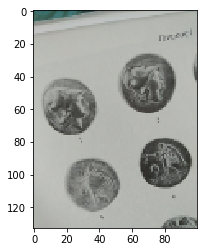

In [2]:
imageName = "cv_coins2.png"
input_image = Image.open(imageName)
plt.imshow(input_image, cmap = "gray")
plt.show()

"Καλούμε τη συνάρτηση sobel_edges() για να μας δώσει την αντίστοιχη δυαδική εικόνα - χάρτη ακμών."

Shape: (133, 100)


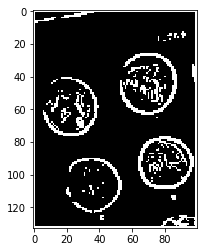

In [3]:
edges_image = sobel_edges(imageName, 0.2)
image = np.array(edges_image)
print("Shape: "+str(image.shape))
plt.imshow(image, cmap = "gray")
plt.show()

"Για τα όρια των ακτινών των κύκλων παίρνουμε τις τιμές 10 και 20, καθώς επίσης ορίζουμε ότι θα μελετήσουμε 250 σημεία για κάθε κύκλο. 
Ισχύει ότι **x = a + r * cos(t)** και **y = b + r * sin(t)**, **t∈[0,2π)**
Χρησιμοποιούμε ένα λεξικό A που θα έχει ως κλειδί, μία πλειάδα με τις τιμές a, b, r και ως τιμή το άθροισμα των φορών που συναντάμε κάθε σημείο."

In [5]:
rmin, rmax = 10, 20 #radius limits
steps = 250

A = {} #Hough dictionary
for x in range(image.shape[0]): #for each pixel
    for y in range(image.shape[1]):
        if image[x][y] == 255: #if pixel is white
            for r in range(rmin, rmax + 1): #for each radius
                for t in range(steps): #for each point in circle
                    a = x - int(r * cos(t * 2 * pi / steps))
                    b = y - int(r * sin(t * 2 * pi / steps))
                    #voting
                    if (a,b,r) in A:
                        A[(a,b,r)] += 1
                    else:
                        A[(a,b,r)] = 1

"Στη συνέχεια, ταξινομούμε τον πίνακα κατά φθίνουσα σειρά με βάση την τιμή και κοιτάμε για κάθε σημείο αν ο μέσος όρος αυτού με όλα τα σημεία του κύκλου που βρέθηκαν, είναι μεγαλύτερος από μία τιμή που ορίσαμε (0,5). Δηλαδή θέλουμε να έχουν εντοπιστεί πολλά σημεία γι' αυτό τον κύκλο. Έπειτα κάνουμε ακόμη έναν έλεγχο για να μην έχουμε πολύ κοντά και άλλους κύκλους. Γενικά θέλουμε να εντοπίσουμε έναν κύκλο για κάθε κυκλική περιοχή στην εικόνα, που να την περικλύει με τον καλύτερο τρόπο."

In [6]:
#select circles
circles = []
for k, v in sorted(A.items(), key=lambda i: -i[1]):
    x, y, r = k
    if v / steps > 0.55: #check if there are enough points in circle
        not_close = False
        for xc, yc, rc in circles: #check if it is not close to other circle
            if (x - xc) ** 2 + (y - yc) ** 2 <= rc ** 2:
                not_close = True
        if not_close == False:
            circles.append((x, y, r))

"Τέλος, σχεδιάζουμε πάνω στην αρχική εικόνα τους κύκλους που εντοπίστηκαν. Προβάλλουμε την νέα εικόνα και την αποθηκεύουμε ως "circles.png"."

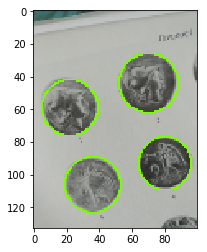

In [27]:
output_image = Image.new("RGB", input_image.size)
output_image.paste(input_image)
draw_result = ImageDraw.Draw(output_image)
for x, y, r in circles:
    draw_result.ellipse((y-r, x-r, y+r, x+r), outline='lawngreen')
output_image.save("circles.png")
plt.imshow(output_image, cmap = "gray")
plt.show()

## **2o ΠΑΡΑΔΕΙΓΜΑ**


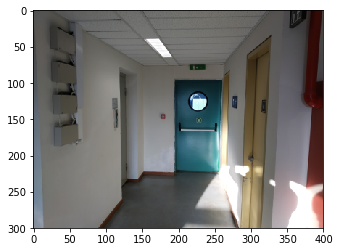

In [28]:
imageName = "cv_firstfloor.png"
input_image = Image.open(imageName)
plt.imshow(input_image, cmap = "gray")
plt.show()

Shape: (300, 400)


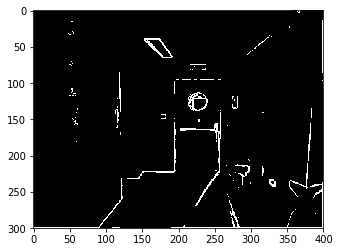

In [29]:
edges_image = sobel_edges(imageName, 0.2)
image = np.array(edges_image)
print("Shape: "+str(image.shape))
plt.imshow(image, cmap = "gray")
plt.show()

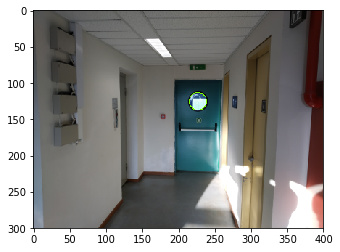

In [30]:
rmin, rmax = 10, 20 #radius limits
steps = 250

A = {} #Hough dictionary
for x in range(image.shape[0]): #for each pixel
    for y in range(image.shape[1]):
        if image[x][y] == 255: #if pixel is white
            for r in range(rmin, rmax + 1): #for each radius
                for t in range(steps): #for each point in circle
                    a = x - int(r * cos(t * 2 * pi / steps))
                    b = y - int(r * sin(t * 2 * pi / steps))
                    #voting
                    if (a,b,r) in A:
                        A[(a,b,r)] += 1
                    else:
                        A[(a,b,r)] = 1
                        
#select circles
circles = []
for k, v in sorted(A.items(), key=lambda i: -i[1]):
    x, y, r = k
    if v / steps > 0.55: #check if there are enough points in circle
        not_close = False
        for xc, yc, rc in circles: #check if it is not close to other circle
            if (x - xc) ** 2 + (y - yc) ** 2 <= rc ** 2:
                not_close = True
        if not_close == False:
            circles.append((x, y, r))
            
output_image = Image.new("RGB", input_image.size)
output_image.paste(input_image)
draw_result = ImageDraw.Draw(output_image)
for x, y, r in circles:
    draw_result.ellipse((y-r, x-r, y+r, x+r), outline='lawngreen')
output_image.save("circles.png")
plt.imshow(output_image, cmap = "gray")
plt.show()